# Predict The Rank of A Team

In [1]:
#general
import io
import os
import shutil
import requests
import base64

#pandas
import pandas as pd

#TensorFlow
import tensorflow as tf
#numpy
import numpy as np

#matplotlib.pylot
import matplotlib.pyplot as plt

#sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Activation

Using TensorFlow backend.


In [2]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
#path
path = "/Users/petronillagriffith/desktop/Fifa"

#import file
filename = os.path.join(path, "fifa_ranking.csv")

#names each column
names = ['rank', 'country', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 
          'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted', 'two_year_ago_avg', 
          'two_year_ago_avg_weighted', 'three_year_ago_avg_', 'three_year_ago_avg_weighted', 'confederation', 'rank_date']

#making a DataFrame
df = pd.read_csv(filename, encoding = "ISO-8859-1", sep=',', na_values=['-1'], index_col=False)

#writes out "Starting File:"
print("Starting File:")


print(df[20:100])


print()

#writes out "Ending File:"
print("Ending File:")

print(df[-10:1])

Starting File:
    rank country_full country_abrv  total_points  previous_points  \
20   139  Afghanistan          AFG        209.53              190   
21   140  Afghanistan          AFG        209.53              210   
22   140  Afghanistan          AFG        209.53              210   
23   140  Afghanistan          AFG        213.85              210   
24   139  Afghanistan          AFG        213.85              214   
25   132  Afghanistan          AFG        227.29              214   
26   133  Afghanistan          AFG        223.41              227   
27   129  Afghanistan          AFG        226.05              223   
28   140  Afghanistan          AFG        183.62              226   
29   138  Afghanistan          AFG        183.62              184   
30   138  Afghanistan          AFG        183.62              184   
31   127  Afghanistan          AFG        213.48              184   
32   122  Afghanistan          AFG        226.23              213   
33   128  Afghanist

In [5]:
df.head(5)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_avg_weighted,three_year_ago_avg,three_year_ago_avg_weighted,confederation,rank_date
0,181,Afghanistan,AFG,70.28,73,-2.0,61.81,61.81,0.0,0.0,8.5,2.55,29.58,5.92,AFC,8/24/11
1,183,Afghanistan,AFG,70.28,70,-2.0,61.81,61.81,0.0,0.0,8.5,2.55,29.58,5.92,AFC,9/21/11
2,184,Afghanistan,AFG,68.58,70,NaN,61.81,61.81,0.0,0.0,0.0,0.00,33.83,6.77,AFC,10/19/11
3,178,Afghanistan,AFG,77.41,69,6.0,70.64,70.64,0.0,0.0,0.0,0.00,33.83,6.77,AFC,11/23/11
4,177,Afghanistan,AFG,85.32,77,1.0,78.55,78.55,0.0,0.0,0.0,0.00,33.83,6.77,AFC,12/21/11


In [6]:
a = df['country_full'].unique().tolist()

byte_offset_map = {}

for i, id in enumerate(a): byte_offset_map[id] = i
    
df['country_full_class'] = df['country_full'].map(lambda x: byte_offset_map[x])

In [7]:
a = df['country_abrv'].unique().tolist()

byte_offset_map = {}

for i, id in enumerate(a): byte_offset_map[id] = i
    
df['country_abrv_class'] = df['country_abrv'].map(lambda x: byte_offset_map[x])

In [8]:
a = df['confederation'].unique().tolist()

byte_offset_map = {}

for i, id in enumerate(a): byte_offset_map[id] = i
    
df['confederation_class'] = df['confederation'].map(lambda x: byte_offset_map[x])

In [9]:
a = df['rank_date'].unique().tolist()

byte_offset_map = {}

for i, id in enumerate(a): byte_offset_map[id] = i
    
df['rank_date_class'] = df['rank_date'].map(lambda x: byte_offset_map[x])

In [10]:
df[1000:1003]

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_avg_weighted,three_year_ago_avg,three_year_ago_avg_weighted,confederation,rank_date,country_full_class,country_abrv_class,confederation_class,rank_date_class
1000,10,Austria,AUT,1090.67,1091,0.0,641.95,641.95,548.70,274.35,414.48,124.35,250.13,50.03,UEFA,2/4/16,12,12,1,54
1001,10,Austria,AUT,1095.41,1091,0.0,641.95,641.95,548.70,274.35,460.54,138.16,204.75,40.95,UEFA,3/3/16,12,12,1,55
1002,11,Austria,AUT,1066.83,1095,NaN,610.71,610.71,548.51,274.26,445.36,133.61,241.30,48.26,UEFA,4/7/16,12,12,1,56


In [11]:
#Drops the 'country' column from the data set
df = df.drop(['country_full'], axis=1)

In [12]:
#Drops the 'country' column from the data set
df = df.drop(['country_abrv'], axis=1)

In [13]:
#Drops the 'confederation' column from the data set
df = df.drop(['confederation'], axis=1)

In [14]:
#Drops the 'confederation' column from the data set
df = df.drop(['rank_date'], axis=1)

In [15]:
df.head(5)

,rank,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_avg_weighted,three_year_ago_avg,three_year_ago_avg_weighted,country_full_class,country_abrv_class,confederation_class,rank_date_class
0,181,70.28,73,-2.0,61.81,61.81,0.0,0.0,8.5,2.55,29.58,5.92,0,0,0,0
1,183,70.28,70,-2.0,61.81,61.81,0.0,0.0,8.5,2.55,29.58,5.92,0,0,0,1
2,184,68.58,70,NaN,61.81,61.81,0.0,0.0,0.0,0.00,33.83,6.77,0,0,0,2
3,178,77.41,69,6.0,70.64,70.64,0.0,0.0,0.0,0.00,33.83,6.77,0,0,0,3
4,177,85.32,77,1.0,78.55,78.55,0.0,0.0,0.0,0.00,33.83,6.77,0,0,0,4


In [16]:
#df[1000:1050]

In [17]:
max = df.loc[df['country_full_class'].idxmax()]

In [18]:
total_country = max['country_full_class']

In [19]:
total_country

210.0

In [20]:
df = df[pd.notnull(df['rank_change'])]

In [21]:
x = (len(df)*.7)
print(int(x))
pt_to_split = int(x)

10614


In [22]:
x = int(len(df)*.7)
pt_to_split = int(x)
print(pt_to_split)

x = df
x_train= df[:pt_to_split]
x_test = df[pt_to_split:]
print(x_train.shape)
print(x_test.shape)

y = df['rank']
y_train = y[:pt_to_split]
y_test = y [pt_to_split:]
print(y_train.shape)
print(y_test.shape)

10614
(10614, 16)
(4550, 16)
(10614,)
(4550,)


In [23]:
df_train = df[:pt_to_split]
df_test = df[pt_to_split+1:]

spots_train = df_train['rank'].tolist()
spots_test = df_test['rank'].tolist()

print("{}".format(len(spots_train)))
print("{}".format(len(spots_test)))

10614
4549


In [24]:
y_train = y[:pt_to_split]
y_test = y [pt_to_split:]
print(y_train.shape)
print(y_test.shape)

(10614,)
(4550,)


In [25]:
y_train = y_train.values.reshape(10614,1)
y_test = y_test.values.reshape(4550,1)

In [26]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10614, 16)
(4550, 16)
(10614, 1)
(4550, 1)


In [ ]:
# Convert all missing values in the specified column to the median
#def missing_median(df, names):
  #  med = df[names].median()
   # df[names] = df[names].fillna(med)

In [ ]:
#missing_median(df, ['rank_change'])

In [ ]:
df[1000:2000]

In [27]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10614, 16)
(4550, 16)
(10614, 1)
(4550, 1)


In [28]:
df.dtypes

rank                             int64
total_points                   float64
previous_points                  int64
rank_change                    float64
cur_year_avg                   float64
cur_year_avg_weighted          float64
last_year_avg                  float64
last_year_avg_weighted         float64
two_year_ago_avg               float64
two_year_ago_avg_weighted      float64
three_year_ago_avg             float64
three_year_ago_avg_weighted    float64
country_full_class               int64
country_abrv_class               int64
confederation_class              int64
rank_date_class                  int64
dtype: object

In [39]:
len(df)

15164

In [29]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping



model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                850       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 2,151
Trainable params: 2,151
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=1,epochs=100)
model.load_weights('best_weights.hdf5') # load weights from best model

Train on 10614 samples, validate on 4550 samples
Epoch 1/100
10614/10614 [==============================] - 1s 112us/step - loss: 1076.2322 - val_loss: 64.4248
Epoch 2/100
10614/10614 [==============================] - 1s 102us/step - loss: 19.8774 - val_loss: 28.7188
Epoch 3/100
10614/10614 [==============================] - 1s 115us/step - loss: 10.2384 - val_loss: 15.4042
Epoch 4/100
10614/10614 [==============================] - 1s 109us/step - loss: 8.0161 - val_loss: 15.4623
Epoch 5/100
10614/10614 [==============================] - 1s 109us/step - loss: 9.3595 - val_loss: 8.3571
Epoch 6/100
10614/10614 [==============================] - 1s 105us/step - loss: 4.1311 - val_loss: 7.6415
Epoch 7/100
10614/10614 [==============================] - 1s 102us/step - loss: 3.3864 - val_loss: 8.8196
Epoch 8/100
10614/10614 [==============================] - 1s 99us/step - loss: 2.7330 - val_loss: 6.8510
Epoch 9/100
10614/10614 [==============================] - 1s 107us/step - loss: 3.2392

In [31]:
# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.41112047374148336


In [33]:
pred[0:1]

array([[ 37.93700027]], dtype=float32)

In [34]:
%matplotlib inline
from matplotlib.pyplot import figure, show

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [36]:
print(pred.shape)
print(y_test.shape)

(4550, 1)
(4550, 1)


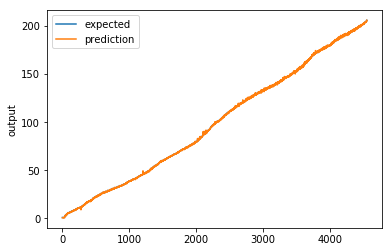

In [37]:
# Plot the chart
chart_regression(pred.flatten(),y_test)

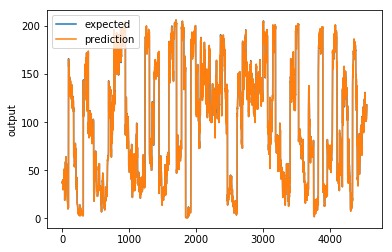

In [38]:
chart_regression(pred.flatten(),y_test,sort=False)